# **Data Visualization**

## Objectives

* Answer Business Requirement 1:
    * The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.

## Inputs

* inputs/cherry_leaves/cherry-leaves/train
* inputs/cherry_leaves/cherry-leaves/validation
* inputs/cherry_leaves/cherry-leaves/test

## Outputs

* Image shape embeddings pkl file
* Mean and variability of images per label plot
* Plot to distinguish the difference between leaves with and without mildew
* Image montage for each label

## Additional Comments

* No additional comments 



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-mildew-detection-in-cherry-leaves/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-mildew-detection-in-cherry-leaves'

---

# Set the Input and Output directories

https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

## Set the input directories

Create variables for the data directory path and its subfolders paths 

In [4]:
# https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

my_data_dir = '/workspace/milestone-project-mildew-detection-in-cherry-leaves/inputs/cherry_leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set the output directories

Create folders and subfolders for storing the results of the research

In [5]:
# https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Import the necessary libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

---

# Labels Distribution


The labels are assessed based on the folder names at the folder of each set (Train, Test, Validation).

In [7]:
sets = os.listdir(my_data_dir)
label_list = []
for set in sets:
    labels=os.listdir(my_data_dir + '/' + set)
    for item in labels:
        if item not in label_list:
            label_list.append(item)

print(label_list)

['healthy', 'powdery_mildew']


The name of the set, the label and its frequency is stored in a DataFrame

In [22]:
# https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/b6cf6ce506324501bcf6aa0f31e0c20c/

freq_list = []
for folder in sets:
  for label in label_list:
    freq_list.append(
      pd.Series(
        {'Set': folder,
        'Label': label,
        'Frequency':len(os.listdir(my_data_dir + '/' + folder + '/' + label))}))
df_freq = pd.DataFrame(freq_list)
joblib.dump(value=df_freq, filename=f"{file_path}/label_dist_freq_df.pkl")
df_freq

,Set,Label,Frequency
0,test,healthy,422
1,test,powdery_mildew,422
2,train,healthy,1472
3,train,powdery_mildew,1472
4,validation,healthy,210
5,validation,powdery_mildew,210


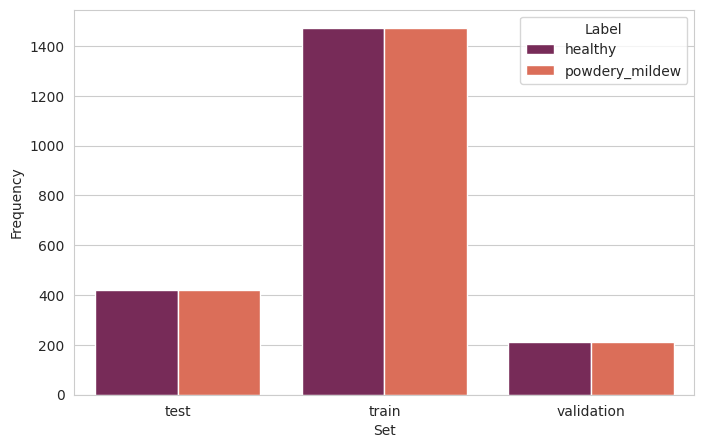

In [10]:
# https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/b6cf6ce506324501bcf6aa0f31e0c20c/

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette='rocket')
plt.savefig(f'{file_path}/labels_distribution_plot.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image shape

### Calculate the average image size on the train set

Create two lists, one storing the image height and the other the image width of the images in the train folder.

In [9]:
# https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

dim1, dim2 = [], []
for label in label_list:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width
dim1_mean = int(sum(dim1) / len(dim1))
dim2_mean = int(sum(dim2) / len(dim2))
print(f'The average height is: {dim1_mean}px')
print(f'The average width is: {dim2_mean}px')

The average height is: 256px
The average width is: 256px


As specified in the Business Requirement 2, the image shape of 256x256 will likely result in a trained model larger than the 100Mb limit. Thus the 100x100 shape will be used. This shape should reduce the image size without compromising the performance. 

In [10]:
image_shape = (100, 100, 3)
image_shape

(100, 100, 3)

Save the image shape embeddings

In [13]:
# https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average Image and Image Variability per Label



Function that loops over a folder finding all the labels subfolders. For each label, all the images will be loaded, resized to the image_shape values, and stored into arrays.

In [11]:
# https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/b6cf6ce506324501bcf6aa0f31e0c20c/

from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(100,100), images_amount = 100):
  
  X, y = np.array([], dtype='int'), np.array([], dtype='object')

  for label in label_list:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      if counter < images_amount:
        
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

2023-06-22 23:37:15.952801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Call the load_image_as_array function on the images in the train directory using the image_shape sizes.

In [12]:
X, y = load_image_as_array(train_path, image_shape, images_amount = 20)
print(X.shape, y.shape)

(40, 100, 100, 3) (40,)


Function that puts a boolean mask over an array to display only the elements matching the given label.

In [13]:
# https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/b6cf6ce506324501bcf6aa0f31e0c20c/
# code in the function

def boolean_mask_for_label(X, y, label_to_display):
    # boolean mask to process only the images of a certain label
    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]
    return arr

Function to calculate the average image and the image variability for each label, then display the average image and image variability in a Figure.

In [14]:
# https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/b6cf6ce506324501bcf6aa0f31e0c20c/

def image_avg_and_variability_data_as_array(X, y, figsize=(12,5), save=False):
  for label_to_display in np.unique(y):

    arr = boolean_mask_for_label(X, y, label_to_display)
  
    avg_image = np.mean(arr, axis=0)
    image_var = np.std(arr, axis=0)
    print('-' * 60)
    print(f'{label_to_display} cherry leaves'.upper())
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title('Average Image')
    axes[0].imshow(avg_image)
    axes[1].set_title('Image Variability')
    axes[1].imshow(image_var)
    if save == True:
      plt.savefig(f'{file_path}/avg_and_var_image_{label_to_display}.png', bbox_inches='tight', dpi=150)
    
    plt.show()
    print('\n')
    
      



Call the image_avg_and_variability_data_as_array function to display the Average Image and Image Variability for each label

------------------------------------------------------------
HEALTHY CHERRY LEAVES


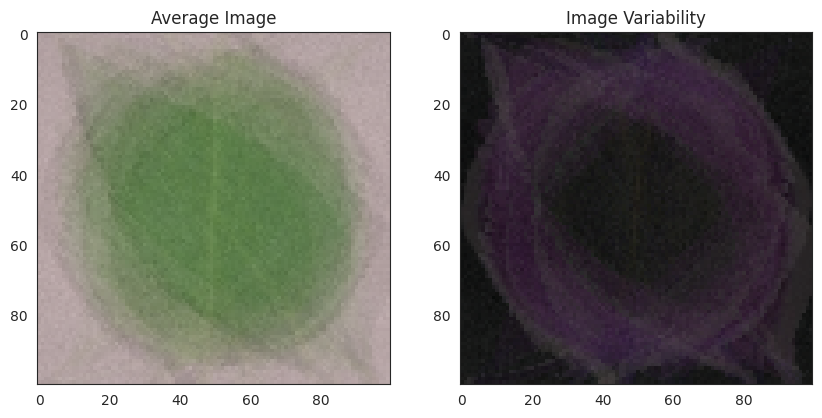



------------------------------------------------------------
POWDERY_MILDEW CHERRY LEAVES


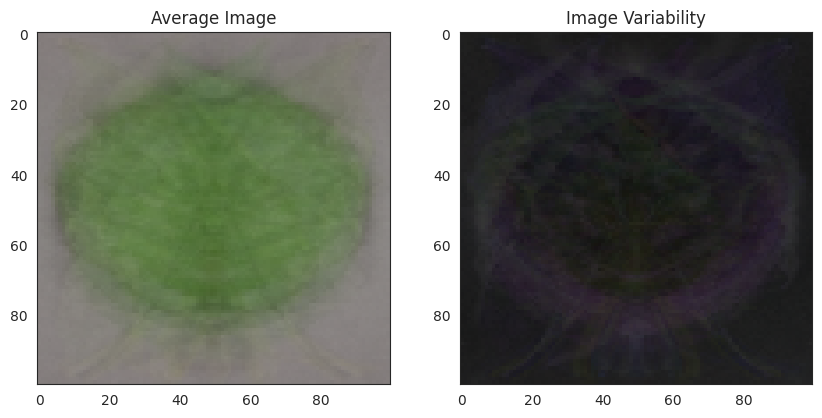

In [15]:
image_avg_and_variability_data_as_array(X=X, y=y, figsize=(10,8), save=True)

---

## Difference between the average image of the healty cherry leaves and the average image of the powdery mildew infected cherry leaves

Function to calculate the difference between the average images of two labels

In [19]:
# https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

def diff_bet_avg_image_labels_data_as_array(X, y, label_1=label_list[0], label_2=label_list[1], figsize=(20, 5), save=False):
    
    # check whether the labels exist in the set of unique labels
    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2}, are not in {np.unique(y)} ")
        return
    
    print(label_1, label_2)

    # calculate the average image from label 1
    label_1_imgs = boolean_mask_for_label(X, y, label_1)
    label_1_avg = np.mean(label_1_imgs, axis=0)
    # calculate the average image from label 2
    label_2_imgs = boolean_mask_for_label(X, y, label_2)
    label_2_avg = np.mean(label_2_imgs, axis=0)
    # calculate the difference between the average images
    avg_difference = label_1_avg - label_2_avg
    # plot the results
    print(f'Difference between the average image of {label_1} and {label_2} cherry leaves'.upper())
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].set_title(f'Average Image of {label_1} cherry leaves')
    axes[0].imshow(label_1_avg)
    axes[1].set_title('Differnce image')
    axes[1].imshow(avg_difference)
    axes[2].set_title(f'Average Image of {label_2} cherry leaves')
    axes[2].imshow(label_2_avg)
    if save == True:
      plt.savefig(f'{file_path}/difference_image.png', bbox_inches='tight', dpi=150)
    
    plt.show()
    print('\n')
      


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


healthy powdery_mildew
DIFFERENCE BETWEEN THE AVERAGE IMAGE OF HEALTHY AND POWDERY_MILDEW CHERRY LEAVES


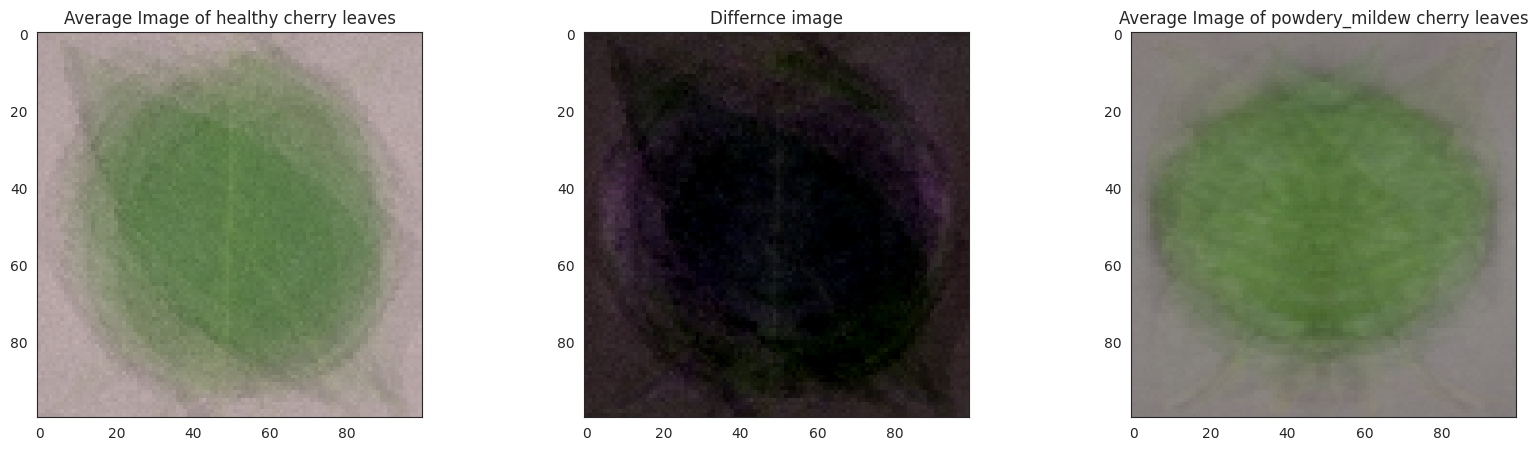

In [20]:
#add condition to check whether the label_list is bigger than 2

diff_bet_avg_image_labels_data_as_array(X, y, save=True)

## Image Montage

In [22]:
import random
def image_montage(dir_path, label, nrows, ncols, figsize=(15, 10)):
    # check if the requested montage size is greater than the subset size
    if label in label_list:
        image_list = os.listdir(f'{dir_path}/{label}')
        length_image_list = len(image_list)
        requested_size = nrows*ncols
        if requested_size < length_image_list:
            image_sample = random.sample(image_list, nrows * ncols)
        elif requested_size == 0:
            print('Either ncols or nrows is 0(zero)')
            return
        else:
            print('The sample size you requested is larger than the amount of images available in the subset')
            print(f'There are {length_image_list} images available')
            print(f'You requested {requested_size} images for your montage')
            print(f'Decrease the nrows or ncols to create a montage')
            return
    
        # create a list of cartesian products of nrows and ncols for axes indices
        plot_idx = []
        for row in range(0,nrows):
            for col in range(0,ncols):
                plot_idx.append((row,col))

        # create the figure to display the image montage
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, requested_size):
            img = imread(f'{dir_path}/{label}/{image_sample[x]}')
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"Please select one of the following options: {label_list}")



------------------------------------------------------------
healthy leaves image montage


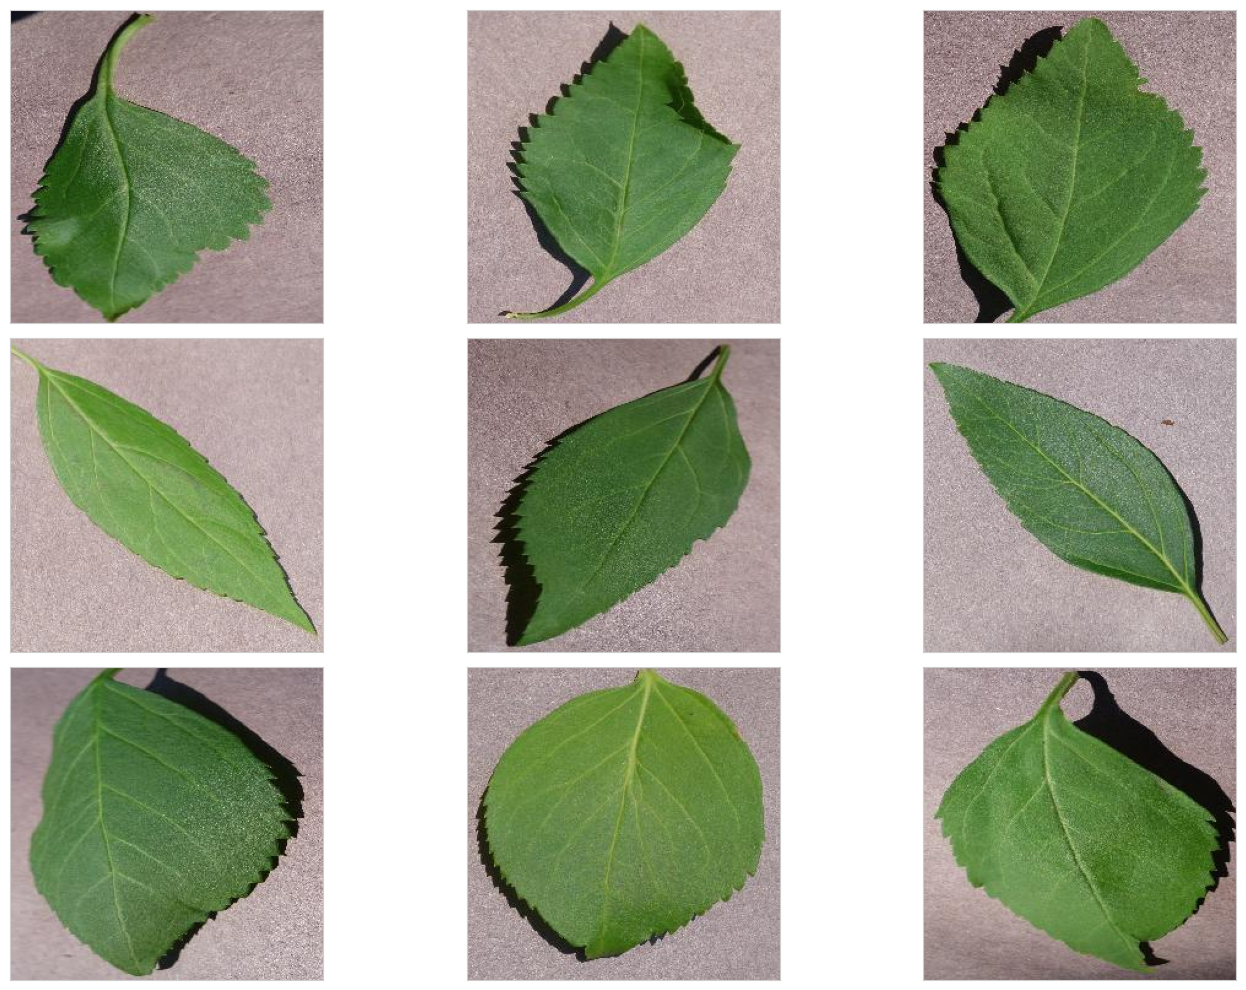



------------------------------------------------------------
powdery_mildew leaves image montage


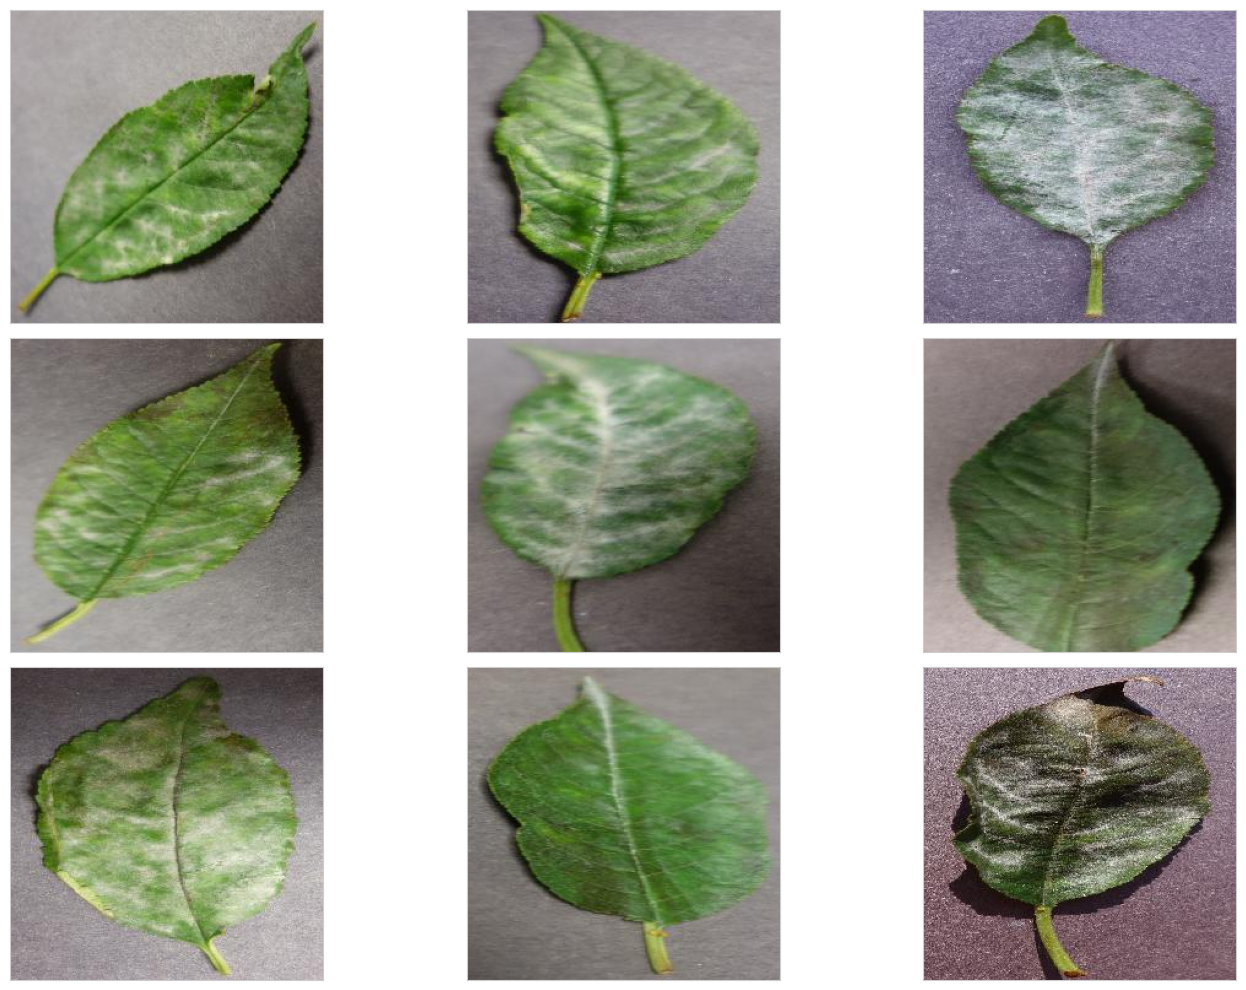

In [23]:
for label in label_list:
    print(60*'-')
    print(f'{label} leaves image montage')
    image_montage(train_path, label, 3, 3, figsize=(15, 10))
    print('\n')

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Conclusions and Next Steps

## Conclusions

* The label distribution and frequency was calculated for each dataset.
* The image shape embeddings were saved in a pickle file.
* The average image was calculated for each label and saved.
* The difference image between the average images of the two labels was calculated and saved.
* An Image Montage has been created for each of the labels 

## Next Steps

* Image augmentation
* Class indices to change prediction inference in labels
* ML model creation and training
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on random image file